<a href="https://colab.research.google.com/github/haosulab/ManiSkill2/blob/tutorials/examples/tutorials/2_robotic_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code

To begin, prepare the colab environment by clicking the play button below. This will install all dependencies for the future code. This can up to 1.5 minutes

In [1]:
!git clone https://github.com/haosulab/ManiSkill2.git
!pip install sapien gym==0.21.0 pyyaml tabulate tqdm h5py transforms3d opencv-python imageio imageio[ffmpeg] trimesh open3d rtree GitPython stable-baselines3
!pip install --upgrade --no-cache-dir gdown # necessary as colab uses an outdated version. see https://github.com/wkentaro/gdown/issues/43
!apt-get install libvulkan-dev
!cd ManiSkill2 && python setup.py develop

Cloning into 'ManiSkill2'...
remote: Enumerating objects: 986, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 986 (delta 190), reused 207 (delta 151), pack-reused 699
Receiving objects: 100% (986/986), 14.31 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (447/447), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.2/669.2 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libvulkan1 mesa-vulkan-drivers
The following NEW packages will be installed:
  libvulkan-dev libvulkan1 mesa-vulkan-drivers
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 3,632 kB of archives.
After this operation, 22.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 mesa-vulkan-drivers amd64 20.0.8-0ubuntu1~18.04.1 [3,059 kB]
Get:2 http://ppa.launchpad.net/graphics-driver

In [22]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

# Robotic Learning Tutorial, basic Imitation Learning and Reinforcement Learning

This notebook will go over two baselines for solving the [ManiSkill](https://github.com/haosulab/ManiSkill2) environments, Imitation Learning and Reinforcement Learning. We will be using the [Stable Baselines 3 (SB3)](https://github.com/DLR-RM/stable-baselines3) package and our own LiftCube enviornment as part of this tutorial with RGBD observations.

A single-file code version of the RL section of this tutorial can be found here: https://github.com/haosulab/ManiSkill2/tree/main/examples/tutorials/sb3_ppo_liftcube.py

First, we will import all required packages

In [23]:
# Import required packages
import gym
import gym.spaces as spaces
from tqdm.notebook import tqdm
import numpy as np
import mani_skill2.envs
from mani_skill2.utils.wrappers import RecordEpisode
import h5py
from mani_skill2.utils.io_utils import load_json
import matplotlib.pyplot as plt
import torch.nn as nn
import torch as th
import cv2
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, VecVideoRecorder
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch.utils.data import Dataset, DataLoader

SB3 won't work out of the box due to observations including depth data as well as being in a format different to what SB3 requires. To remind ourselves, lets create an environment and inspect the observations

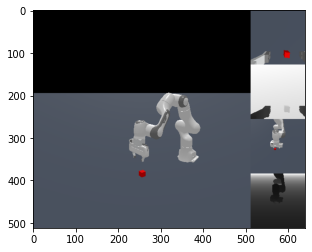

In [2]:
env_id = "LiftCube-v0"
obs_mode = "rgbd"
control_mode = "pd_ee_delta_pose"
reward_mode = "dense"
# create our environment with our configs and then reset to a clean state
env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode)
obs = env.reset()

# take a look at the current state
img = env.render(mode="cameras")
plt.imshow(img)
env.close()

In [3]:
# the observations
print("The raw observation", obs.keys()) 
print("The data in the observation:")
print("image", obs["image"].keys())
print("agent", obs["agent"].keys())
print("extra", obs["extra"].keys())

The raw observation odict_keys(['image', 'agent', 'extra'])
The data in the observation:
image odict_keys(['hand_camera', 'base_camera'])
agent odict_keys(['qpos', 'qvel', 'controller', 'base_pose'])
extra odict_keys(['tcp_pose'])


There's quite a few things, all of which are important for solving the robotics environments! For in-depth details on the exact data stored here, see the wiki: https://github.com/haosulab/ManiSkill2/wiki/Observation-Space

## 1 Adapting ManiSkill environments for Stable Baselines with an Observation Wrapper

If you look at the observation space and the returned observation, you will notice that it is a nested dictionary with different values in there, including both image data from cameras and state data about the robot.

SB3 won't be able to use this out of the box so we can define a custom observation wrapper to make the ManiSkill environment conform with SB3. Here, we are simply going to take the two RGB images, two depth images from both cameras (base camera and hand camera) and the state data and create a workable observation for SB3.

Feel free to the use the code as is and skip this section. If you want additional customization such as using robot segmentation data, point cloud data etc., you will need to edit the below wrapper appropriately.

In [4]:
class ManiSkillRGBDWrapper(gym.ObservationWrapper):
    def __init__(self, env, image_size=(128, 128)) -> None:
        super().__init__(env)
        obs_space = env.observation_space
        self.image_size = image_size
        
        # We want the following states to be kept in the observations. 
        # obs_space is the original environment's observation space
        state_spaces = [
            obs_space["agent"]['base_pose'], # pose of the robot
            obs_space["agent"]['qpos'], # robot configuration position
            obs_space["agent"]['qvel'], # robot configuration velocity
        ]
        for k in obs_space["extra"]:
            # includes gripper pose and goal information depending on environment
            state_spaces.append(obs_space["extra"][k])
        # Define the new state space
        state_size = sum([space.shape[0] for space in state_spaces])
        state_space = spaces.Box(-float("inf"), float("inf"), shape=(state_size, ))
        
        # Get the image dimensions. Note that there is a base_camera and a hand_camera, both of which output the same shape
        h, w, _ = obs_space["image"]["base_camera"]["rgb"].shape
        if self.image_size is not None:
            h, w = self.image_size
        new_shape = (h, w, 8) # the shape is HxWx8, where 8 comes from combining two RGB images and two depth images
        low = np.full(new_shape, -float("inf"))
        high = np.full(new_shape, float("inf"))
        rgbd_space = spaces.Box(low, high, dtype=obs_space["image"]["base_camera"]["rgb"].dtype)
        
        # create the observation space
        self.observation_space = spaces.Dict({
            "rgbd": rgbd_space,
            "state": state_space
        })

    @staticmethod # make this static so both RL and IL tutorials can use this
    def convert_observation(observation, image_size):
        # This function replaces the original observations. We scale down images by 255 and 
        # flatten the states in the original observations
        image_obs = observation["image"]
        rgb = image_obs["base_camera"]["rgb"] / 255.0
        depth = image_obs["base_camera"]["depth"]
        rgb2 = image_obs["hand_camera"]["rgb"] / 255.0
        depth2 = image_obs["hand_camera"]["depth"]

        # optionally resize images
        if image_size is not None and image_size != (rgb.shape[0], rgb.shape[1]):
            rgb = cv2.resize(rgb, image_size, interpolation=cv2.INTER_LINEAR)
            depth = cv2.resize(depth, image_size, interpolation=cv2.INTER_LINEAR)[:,:,None]
            rgb2 = cv2.resize(rgb2, image_size, interpolation=cv2.INTER_LINEAR)
            depth2 = cv2.resize(depth2, image_size, interpolation=cv2.INTER_LINEAR)[:,:,None]
        from mani_skill2.utils.common import flatten_state_dict
        state = np.hstack([
            flatten_state_dict(observation["agent"]),
            flatten_state_dict(observation["extra"])
        ])
        
        # combine the RGB and depth images
        rgbd = np.concatenate([rgb, depth, rgb2, depth2], axis=2)
        obs = dict(rgbd=rgbd, state=state)
        return obs
    def observation(self, observation):
        return ManiSkillRGBDWrapper.convert_observation(observation, image_size=self.image_size)

    def step(self, action):
        o, r, d, info = super().step(action)
        d = False
        if info["elapsed_steps"] >= 100:
            # trunate episodes after 100 steps rather than the default 200 steps for faster training
            # set TimeLimit.truncated to True to tell SB3 it's a truncation and not task success
            info["TimeLimit.truncated"] = True
            d = True
        return o,r,d,info


We can now wrap the original environment and we'll see the returned observations are now more compact and importantly usable by SB3

In [5]:
env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode)
env = ManiSkillRGBDWrapper(env)
obs = env.reset()
print(obs.keys())
print("rgbd shape", obs["rgbd"].shape)
print("state shape", obs["state"].shape)
env.close()

dict_keys(['rgbd', 'state'])
rgbd shape (128, 128, 8)
state shape (32,)


## 2 Creating a model to process RGBD and State data

SB3 natively doesn't support processing RGB data with depth information, so we will need to create a custom network to process that data. We can make use of the SB3 BaseExtractor class to do this so we can fit our model into any of SB3's algorithms. For more details on feature extractors see the SB3 docs: https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html#custom-feature-extractor

The following code will be useful for creating features from observations in both reinforcement learning and imitation learning

In [6]:
class CustomExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        super().__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        feature_size = 256

        for key, subspace in observation_space.spaces.items():
            # We go through all subspaces in the observation space.
            # We know there will only be "rgbd" and "state", so we handle those below
            if key == "rgbd":
                # here we use a NatureCNN architecture to process images, but any architecture is permissble here
                in_channels = subspace.shape[-1]
                cnn = nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                    nn.ReLU(),
                    nn.Flatten()
                )
                
                # to easily figure out the dimensions after flattening, we pass a test tensor
                test_tensor = th.zeros([subspace.shape[2], subspace.shape[0], subspace.shape[1]])
                with th.no_grad():
                    n_flatten = cnn(test_tensor[None]).shape[1]
                fc = nn.Sequential(nn.Linear(n_flatten, feature_size), nn.ReLU())
                extractors["rgbd"] = nn.Sequential(cnn, fc)
                total_concat_size += feature_size
            elif key == "state":
                # for state data we simply pass it through a single linear layer
                state_size = subspace.shape[0]
                extractors["state"] = nn.Linear(state_size, 64)
                total_concat_size += 64

        self.extractors = nn.ModuleDict(extractors)
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []
        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            if key == "rgbd":
                observations[key] = observations[key].permute((0, 3, 1, 2))
            encoded_tensor_list.append(extractor(observations[key]))
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return th.cat(encoded_tensor_list, dim=1)

## 3 Robotic Learning (RL and IL)

This section will go through how to train your agent to solve the PickCube task with SB3, using the code we've written above. First to setup, we will define a `make_env` function which enables creating the desired environment easily, vectorize it, as well as record videos locally during training.

In [7]:
def make_env(env_id: str, rank: int, seed: int = 0, record_dir = None):
    def _init() -> gym.Env:
        import mani_skill2.envs
        env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode)
        env.goal_height = 0.15 # make env easier so we can train faster for tutorial purposes
        env = ManiSkillRGBDWrapper(env, image_size=(128,128))
        if record_dir is not None:
            env = RecordEpisode(env, record_dir, info_on_video=True, render_mode="cameras")
        env.seed(seed+rank)
        return env
    set_random_seed(seed)
    return _init

### 3.1 Reinforcement Learning

We have a custom model / feature extractor ready, an observation wrapper that allows SB3 to work with ManiSkill environments, now that is left is to setup an RL agent and train, evaluate, and monitor it. In this tutorial we will use PPO.

First, we will create vectorized environments to speed up training by creating a `make_env` function. In this function we also add a parameter `record` to let you create environments that automatically record videos and saves them locally during training/evaluation.

In [10]:
num_cpu = 2 # you can increases this and decrease the n_steps parameter if you have more cores to speed up training

# create one eval environment
eval_env = SubprocVecEnv([make_env(env_id, i, record_dir="logs/videos") for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.reset()

# create num_cpu training environments
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])
env = VecMonitor(env)
obs = env.reset()

To help monitor our training, we can create an evaluation callback function as well as a checkpoint callback function using SB3. The evaluation callback will periodically evaluate the agent without noise and save results to the logs folder. The `eval_env` has `record=True` so it will also save videos to `logs/videos`. Whenever the evaluation reward has improved, it will save a new best model as well. The checkpoint callback will periodically save the training progress over time. 

In [11]:
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/",
                         log_path="./logs/", eval_freq=4000*8,
                         deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(
    save_freq=4000*8,
    save_path="./logs/",
    name_prefix="rl_model",
    save_replay_buffer=True,
    save_vecnormalize=True,
)

#### 3.1.1 RL Training with PPO
Finally, we can begin training. We will define the policy configuration as well as training configuration. The configs provided are tuned are already and will be able to train out a succesful LiftCube policy. The configs are set to perform a rollout of 3200 steps split across each parallel environment, and update the policy with batch size 400 for 5 epochs. Once we've interacted with the environment for over 200_000 steps, training is stopped and the final model is saved to `logs/latest_model`.

To keep track of training progress you can go to `logs/videos` and download the evaluation videos saved during training. This can take up to 2 hours to finish training on Google Colab. To speed up training you can use a compute with more CPU cores and/or a more powerful GPU.

In [ ]:
set_random_seed(0)
rollout_steps = 3200
policy_kwargs = dict(features_extractor_class=CustomExtractor, net_arch=[256, 128])
model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
    n_steps=rollout_steps // num_cpu, batch_size=400,
    n_epochs=5,
    tensorboard_log="./logs",
    gamma=0.8,
    target_kl=0.2,
    ent_coef=0,
    max_grad_norm=0.5,
    learning_rate=3e-4
)
model.learn(200_000, callback=[checkpoint_callback, eval_callback],)
model.save("./logs/latest_model")

# optionally load back the model that was saved
model = model.load("./logs/latest_model")

#### 3.1.2 Evaluation
Once a model is trained, whether you ran the script above or downloaded the pretrained policy, you can run below to evaluate it and save some videos. Turn render=True if you have a GUI


In [ ]:
eval_env.close() # close the old eval env
# make a new one that saves to a different directory
eval_env = SubprocVecEnv([make_env(env_id, i, record_dir="logs/eval_videos") for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.reset()

results = evaluate_policy(model, eval_env, deterministic=True, render=False, return_episode_rewards=True, n_eval_episodes=5)
print(results)

([213.22704, 210.63857, 212.30019, 213.22131, 215.07123], [100, 100, 100, 100, 100])


In [ ]:
from IPython.display import Video
Video("./logs/eval_videos/2.mp4", embed=True) # Watch one of the replays

### 3.2 Imitation Learning (BC)

An alternative approach to solving this problem is to use the demonstration dataset provided. One way to utilize the dataset is to simply supervise learn the observation-action pairs in it, also known as Behavior Cloning. The tutorial here shows a basic usage of a demonstration dataset to then behavior clone through PyTorch, however due to the difficulty of PickCube, it will only make some progress to solving the environment.

If you haven't downloaded and transformed a demonstration dataset yet for your desired env, you can run the following code.

In [14]:
# download PickCube-v0 demonstrations to the demos folder
!python -m mani_skill2.utils.download_demo PickCube-v0 -o demos 

Retrieving folder list
Processing file 1Oh2aBU1WAqMy32oAuvTL7uy_g5K55K-r trajectory.h5
Processing file 1t4FXn6y_zo_Tv8FhptugnyhrTg5nO1_q trajectory.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Oh2aBU1WAqMy32oAuvTL7uy_g5K55K-r
To: /content/demos/rigid_body/PickCube-v0/trajectory.h5
100% 34.2M/34.2M [00:00<00:00, 77.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1t4FXn6y_zo_Tv8FhptugnyhrTg5nO1_q
To: /content/demos/rigid_body/PickCube-v0/trajectory.json
100% 325k/325k [00:00<00:00, 151MB/s]
Download completed


In [ ]:
# recommended to run this on a separate terminal, this can be fairly slow if you only have a few CPU cores
!python -m mani_skill2.trajectory.replay_trajectory --traj-path demos/rigid_body/PickCube-v0/trajectory.h5 --save-traj \
    --target-control-mode pd_ee_delta_pose --obs-mode rgbd --num-procs 2

In [21]:
# or to skip the slow replay of trajectories you can download a 
# pre-transformed demonstration dataset with rgbd observations and a pd_ee_delta_pose controller 
!gdown "https://drive.google.com/drive/folders/1JzbMYCNjNug61BNBt3b0n__a89SIjS6f?usp=share_link" --folder -O demos/rigid_body/

Retrieving folder list
Processing file 1pxV8OhPRtg1voUsCm2lpvIQRMvZb8o7e trajectory.rgbd.pd_ee_delta_pose.h5
Processing file 190kSLEYAAX-ovKFZPpxAXhEujcxBEwm6 trajectory.rgbd.pd_ee_delta_pose.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1pxV8OhPRtg1voUsCm2lpvIQRMvZb8o7e
To: /content/demos/rigid_body/PickCube-v0/trajectory.rgbd.pd_ee_delta_pose.h5
100% 825M/825M [00:09<00:00, 89.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=190kSLEYAAX-ovKFZPpxAXhEujcxBEwm6
To: /content/demos/rigid_body/PickCube-v0/trajectory.rgbd.pd_ee_delta_pose.json
100% 328k/328k [00:00<00:00, 56.8MB/s]
Download completed


#### 3.2.1 Defining a Dataset to load demonstration data
To leverage the dataset, in Pytorch we can create a [Dataset and DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to make iterating over the data easier. The Dataset loads a desired .h5 demonstration file, as well as re-using the observation wrapper code in `ManiSkillRGBDWrapper` to convert observations to ones that suit our policy.

If you want to make your own dataset, be aware of a few caveats of how demonstrations are stored. 

- For space conservation depth data is scale by `2**10` and stored as `np.uint16`. The code below rescales it back by dividing by `2**10`.
- When loading h5py data via `h5py.File(dataset_file, "r")` this simply loads a "reference" and does not load all the data into memory. To speed up data loading it's recommended to load into memory by using the `load_h5_data` function below. Be wary that this can be very memory intensive

In [8]:
def load_h5_data(data):
    out = dict()
    for k in data.keys():
        if isinstance(data[k], h5py.Dataset):
            out[k] = data[k][:]
        else:
            out[k] = load_h5_data(data[k])
    return out
class ManiSkillRGBDDataset(Dataset):
    def __init__(self, dataset_file: str, image_size=(128, 128), load_count = -1) -> None:
        self.dataset_file = dataset_file
        self.image_size = image_size
        import h5py
        from mani_skill2.utils.io_utils import load_json

        # Load the trajectory data from the .h5 file
        self.data = h5py.File(dataset_file, "r")

        # Load associated json
        json_path = dataset_file.replace(".h5", ".json")
        self.json_data = load_json(json_path)

        self.episodes = self.json_data["episodes"] # each episode/demonstration meta data
        self.env_info = self.json_data["env_info"]
        self.env_id = self.env_info["env_id"]
        self.env_kwargs = self.env_info["env_kwargs"]
        
        def load_h5_data(data):
            out = dict()
            for k in data.keys():
                if isinstance(data[k], h5py.Dataset):
                    out[k] = data[k][:]
                else:
                    out[k] = load_h5_data(data[k])
            return out
        self.trajectories = []
        self.total_frames = 0
        if load_count == -1:
            load_count = len(self.episodes)
        for eps_id in tqdm(range(load_count)):
            eps = self.episodes[eps_id]
            ep_len = eps["elapsed_steps"]
            self.total_frames += 200 # pad each trajectory to 200 so we can easily sample trajectories and frames later
            trajectory = self.data[f"traj_{eps['episode_id']}"]
            
            trajectory = load_h5_data(trajectory)
            self.trajectories.append(trajectory)

    def __len__(self):
        return self.total_frames

    def __getitem__(self, idx):
        # sample frame by uniformally sampling trajectory, then sampling a frame
        trajectory_id = idx // 200 # divide by 200, the padded amount
        trajectory = self.trajectories[trajectory_id]
        frame_id = idx % len(trajectory["actions"])
        action = th.from_numpy(trajectory["actions"][frame_id])
        def select_index_dict(data, index):
            out = dict()
            for k in data:
                if isinstance(data[k], dict):
                    out[k] = select_index_dict(data[k], index)
                else:
                    out[k] = data[k][index]
            return out
        obs = select_index_dict(trajectory["obs"], frame_id)
        # we can reuse the observation wrapper code here to convert the demonstration dataset observations into ones for the model
        obs = ManiSkillRGBDWrapper.convert_observation(obs, image_size=self.image_size)
        # for space conservation depth data is stored in uint16 and scaled by 2**10, we transform it back to the right scale here
        obs['rgbd'][:,:,3] = obs['rgbd'][:,:,3] / (2**10)
        obs['rgbd'][:,:,7] = obs['rgbd'][:,:,7] / (2**10)
        for k in obs:
            obs[k] = th.from_numpy(obs[k]).float()
        return obs, action

#### 3.2.2 Defining a policy

With the dataset class created, we can now build our policy that we want to train to imitate the dataset demonstrations. We can build upon our code with building a feature extractor by simply adding a MLP layer on top to predict actions in the action space

In [9]:
class Policy(nn.Module):
    def __init__(self, observation_space, action_space, hidden_units=[128, 128], activation=nn.ReLU):
        super().__init__()
        self.feature_extractor = CustomExtractor(observation_space)
        mlp_layers = []
        prev_units = self.feature_extractor._features_dim
        for h in hidden_units[:-1]:
            mlp_layers += [nn.Linear(prev_units, h), activation()]
            prev_units = h
        mlp_layers += [nn.Linear(prev_units, action_space.shape[0]), nn.Tanh()]
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, observations) -> th.Tensor:
        features = self.feature_extractor(observations)
        return self.mlp(features)

In [20]:
# create an evaluation environment that records to logs/videos, as well as give us the observation space and action space
env_id = "PickCube-v0"
eval_env = make_env(env_id, 0, record_dir="logs/videos")()
eval_env.reset()

policy = Policy(eval_env.observation_space, eval_env.action_space, hidden_units=[256, 128], activation=nn.Tanh)
# move model to gpu if possible
device = "cuda" if th.cuda.is_available() else "cpu"
policy = policy.to(device)

#### 3.2.3 Training with Behavior Cloning

To train with BC, we simply do a supervised learning task by repeatedly sampling batches of observation action pairs from the dataset and optimizing the policy to predict the actions from observations.

We first create a Dataloader object using our Dataset class. Due to the number of demonstrations the dataset loading can take up to 2 minutes to load. Loading all 1000 demonstrations can also take around 14GB of RAM. Set `load_count` to lower than 1000 to limit how many demonstrations are loaded.

In [11]:
dataset = ManiSkillRGBDDataset(dataset_file="./demos/rigid_body/PickCube-v0/trajectory.rgbd.pd_ee_delta_pose.h5", load_count=200)
dataloader = DataLoader(dataset, batch_size=256, num_workers=0, pin_memory=True, drop_last=True, shuffle=True)

  0%|          | 0/200 [00:00<?, ?it/s]

We can now start training with the code snippet below, which simply repeatedly iterates over batches of data from the dataloader and optimizes the model with Adam.

In [25]:
iterations = 30000 # @param
learning_rate = 1e-4 # @param
# create a logger with Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/bc_pickcube")

# create loss function and optimizer
loss_fn = nn.MSELoss()
optim = th.optim.Adam(policy.parameters(), lr=learning_rate)

best_epoch_loss = 9999
pbar = tqdm(dataloader, total=iterations)
epoch = 0
steps = 0

# a short save function to save our model
def save_model(path):
    save_data = dict(
        policy=policy.state_dict(),
        step=steps,
        best_epoch_loss=best_epoch_loss,
    )
    print(f"saving model to {path}")
    th.save(save_data, path)

while True:
    epoch_loss = 0
    for batch in dataloader:
        steps += 1
        optim.zero_grad()
        observations, actions = batch
        for k in observations:
            observations[k] = observations[k].to(device)
        actions = actions.to(device)
        pred_actions = policy(observations)
        
        # compute loss and optimize
        loss = loss_fn(actions, pred_actions)
        loss.backward()
        loss_val = loss.item()
        optim.step()

        # track the loss and print it
        writer.add_scalar("train/mse_loss", loss_val, steps)
        epoch_loss += loss_val
        pbar.set_postfix(dict(loss=loss_val))
        pbar.update(1)

        # periodically save the policy
        if steps % 10000 == 0:
            save_model(f"ckpt_{steps}.pt")
        if steps >= iterations:
            # stop after max iterations
            break
    
    epoch_loss = epoch_loss / len(dataloader)

    # save a new model if the average MSE loss in an epoch has improved
    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        print(f"New best loss {best_epoch_loss}")
        save_model("ckpt_best.pt")
    
    writer.add_scalar("train/mse_loss_epoch", epoch_loss, epoch)
    epoch += 1
    if steps >= iterations:
        # stop after max iterations
        break
save_model("ckpt_latest.pt")

  0%|          | 0/30000 [00:00<?, ?it/s]

New best loss 0.06076665640545961
saving model to ckpt_best.pt
New best loss 0.010997763166251855
saving model to ckpt_best.pt


KeyboardInterrupt: ignored

In [28]:
20152 % 200

152

In [27]:
len(dataset)

20152

#### 3.2.4 Evaluation

We can now intract with the evaluation environment with our trained policy and save videos of the results / watch them if a GUI is available.

In [26]:
traj_id = 0
obs=eval_env.reset(seed=traj_id)
policy.eval()
for i in range(10000):
    # move the observation to GPU
    o = dict()
    for k in obs:
        o[k] = th.from_numpy(obs[k]).float()[None].to(device)
    with th.no_grad():
        acts = policy(o)
        acts = acts.cpu().numpy()[0]
    obs, r, d, info = eval_env.step(acts)

    if not IN_COLAB: eval_env.render()
    info = info
    d=d
    if info["success"]:
        print("success")
        print(f"Episode {traj_id} successful")
        traj_id += 1
        obs=eval_env.reset(seed=traj_id)
    elif d:
        print(f"Episode {traj_id} unsuccessful")
        traj_id += 1
        obs = eval_env.reset(seed=traj_id)

Episode 0 unsuccessful
Episode 1 unsuccessful
Episode 2 unsuccessful
Episode 3 unsuccessful
Episode 4 unsuccessful
Episode 5 unsuccessful


KeyboardInterrupt: ignored